# Explore vorticity@850hPa data

In [ ]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import mlde_utils
from mlde_utils.plotting import cp_model_rotated_pole, platecarree, plot_map

In [ ]:
VARIABLE="vorticity850"
DOMAIN="birmingham-64"
FREQUENCY="day"
TARGET_RESOLUTION="2.2km-coarsened-4x"

def open_ds(data_resolution, variable=VARIABLE):
    resolution=f"{data_resolution}-{TARGET_RESOLUTION}"
    ds_meta = mlde_utils.VariableMetadata(os.getenv("MOOSE_DERIVED_DATA"), resolution=resolution, variable=variable, frequency=FREQUENCY, domain=DOMAIN)
    ds = xr.open_mfdataset(ds_meta.existing_filepaths())
    return ds

## GCM-derived

## GCM 60km regriddded (NN)

In [ ]:
gcm_ds = open_ds("60km")
gcm_ds

<xarray.Dataset>
Dimensions:                     (time: 21600, grid_latitude: 64,
                                 grid_longitude: 64, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 2080-11...
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
Dimensions without coordinates: bnds
Data variables:
    vorticity850                (time, grid_latitude, grid_longitude) float64 dask.array<chunksize=(360, 64, 64), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    grid_latitude_bnds          (time, grid_latitude, bnds) float32 dask.array<chunksize=(360, 64, 2), meta=np.ndarray>
    grid_longitude_bnds         (time, grid_longitude, bnds) float32 dask.array<chunksize=(360, 64, 2), meta=np.ndarray>
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7

## CPM-derived

### Coarsened CPM

In [ ]:
cpm_coarsened_ds = open_ds("2.2km-coarsened-gcm")
cpm_coarsened_ds

<xarray.Dataset>
Dimensions:                     (time: 21600, grid_latitude: 64,
                                 grid_longitude: 64, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 2080-11...
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
Dimensions without coordinates: bnds
Data variables:
    vorticity850                (time, grid_latitude, grid_longitude) float64 dask.array<chunksize=(360, 64, 64), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    grid_latitude_bnds          (time, grid_latitude, bnds) float32 dask.array<chunksize=(360, 64, 2), meta=np.ndarray>
    grid_longitude_bnds         (time, grid_longitude, bnds) float32 dask.array<chunksize=(360, 64, 2), meta=np.ndarray>
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    source:       Data from Met Office Unified Model
    um_version:   10.6
    history:      Fri Jul 29 15:57:58 2022: cdo -O -s -f nc -remapcon,/home/u...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

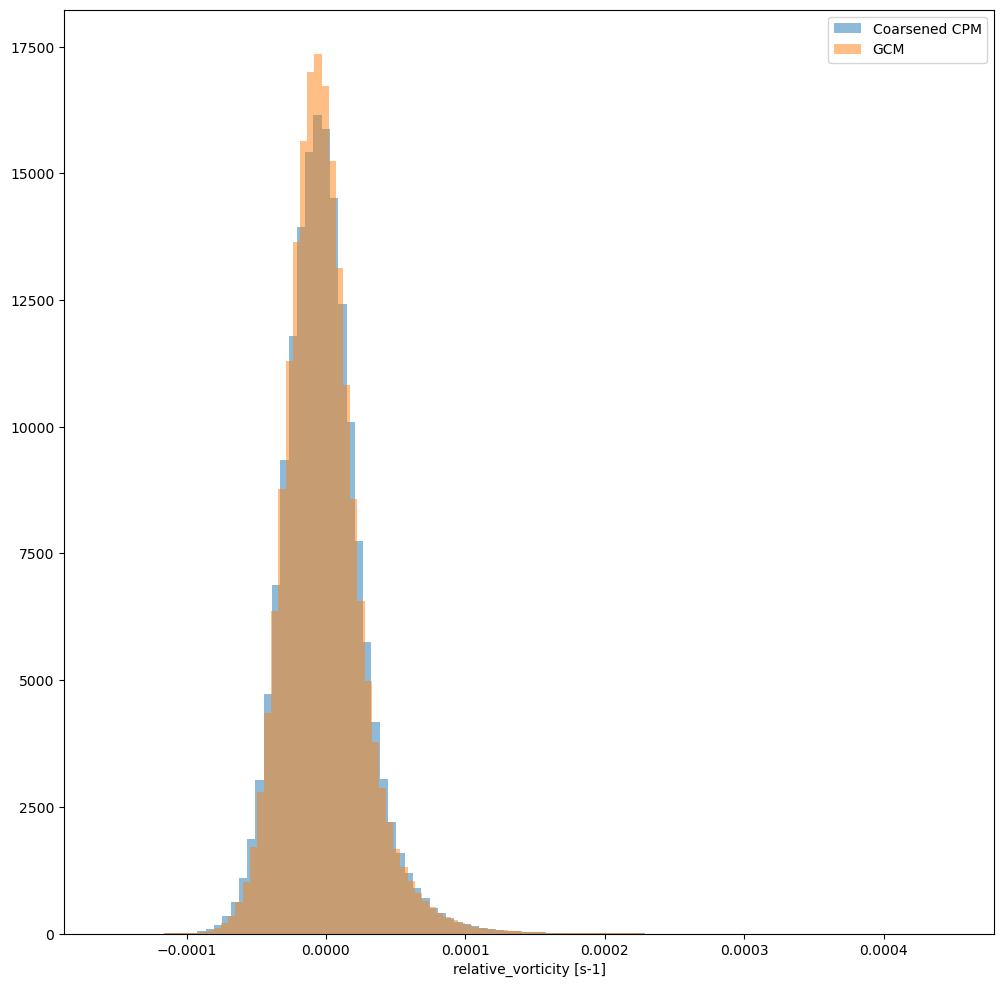

In [ ]:
fig, axd = plt.subplot_mosaic([["Hist"]], figsize=(12,12))

ax = axd["Hist"]
bins = 100
# _, bins, _   = uncoarsened_ds[VARIABLE].plot.hist(ax=ax, bins=bins, alpha=0.5, density=True, label="2.2km")
cpm_coarsened_ds[VARIABLE].plot.hist(ax=ax, bins=bins, alpha=0.5, density=True, label="Coarsened CPM")
gcm_ds[VARIABLE].plot.hist(ax=ax, bins=bins, alpha=0.5, density=True, label="GCM")
ax.legend()

plt.show()

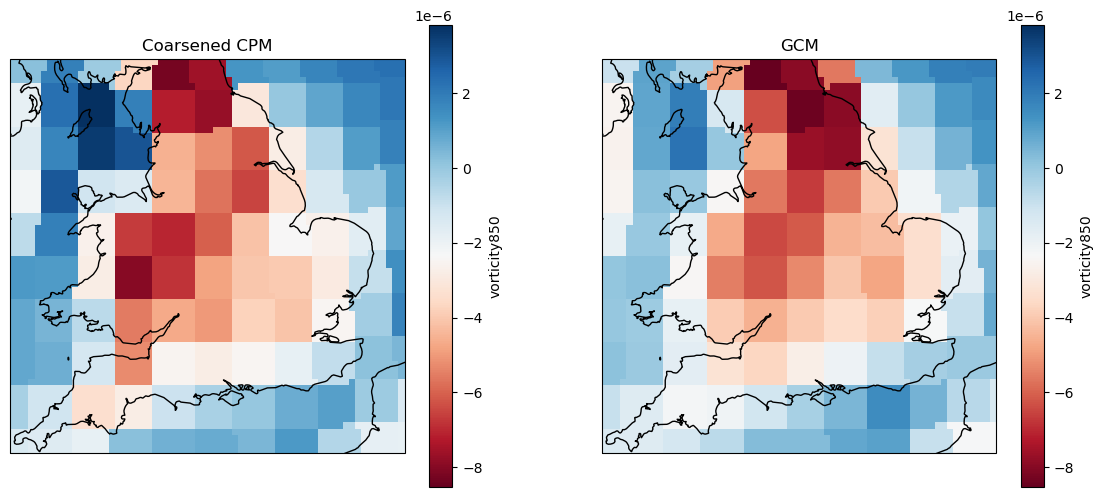

In [ ]:
fig, axd = plt.subplot_mosaic([["CPM Mean", "GCM Mean"]], figsize=(14,6), subplot_kw={"projection": cp_model_rotated_pole})

cpm_coarsened_mean = cpm_coarsened_ds[VARIABLE].mean(dim=["time"])
gcm_mean = gcm_ds[VARIABLE].mean(dim=["time"])

vmax = max(cpm_coarsened_mean.max().values, gcm_mean.max().values)
vmin = min(cpm_coarsened_mean.min().values, gcm_mean.min().values)

ax = axd["CPM Mean"]
plot_map(cpm_coarsened_mean, ax=ax, norm=None, cmap="RdBu", vmin=vmin, vmax=vmax, add_colorbar=True, title="Coarsened CPM")
# cpm_coarsened_ds[VARIABLE].mean(dim=["time"]).plot(ax=ax)

ax = axd["GCM Mean"]
# gcm_ds[VARIABLE].mean(dim=["time"]).plot(ax=ax)
plot_map(gcm_mean, ax=ax, norm=None, cmap="RdBu", vmin=vmin, vmax=vmax, add_colorbar=True, title="GCM")

plt.show()

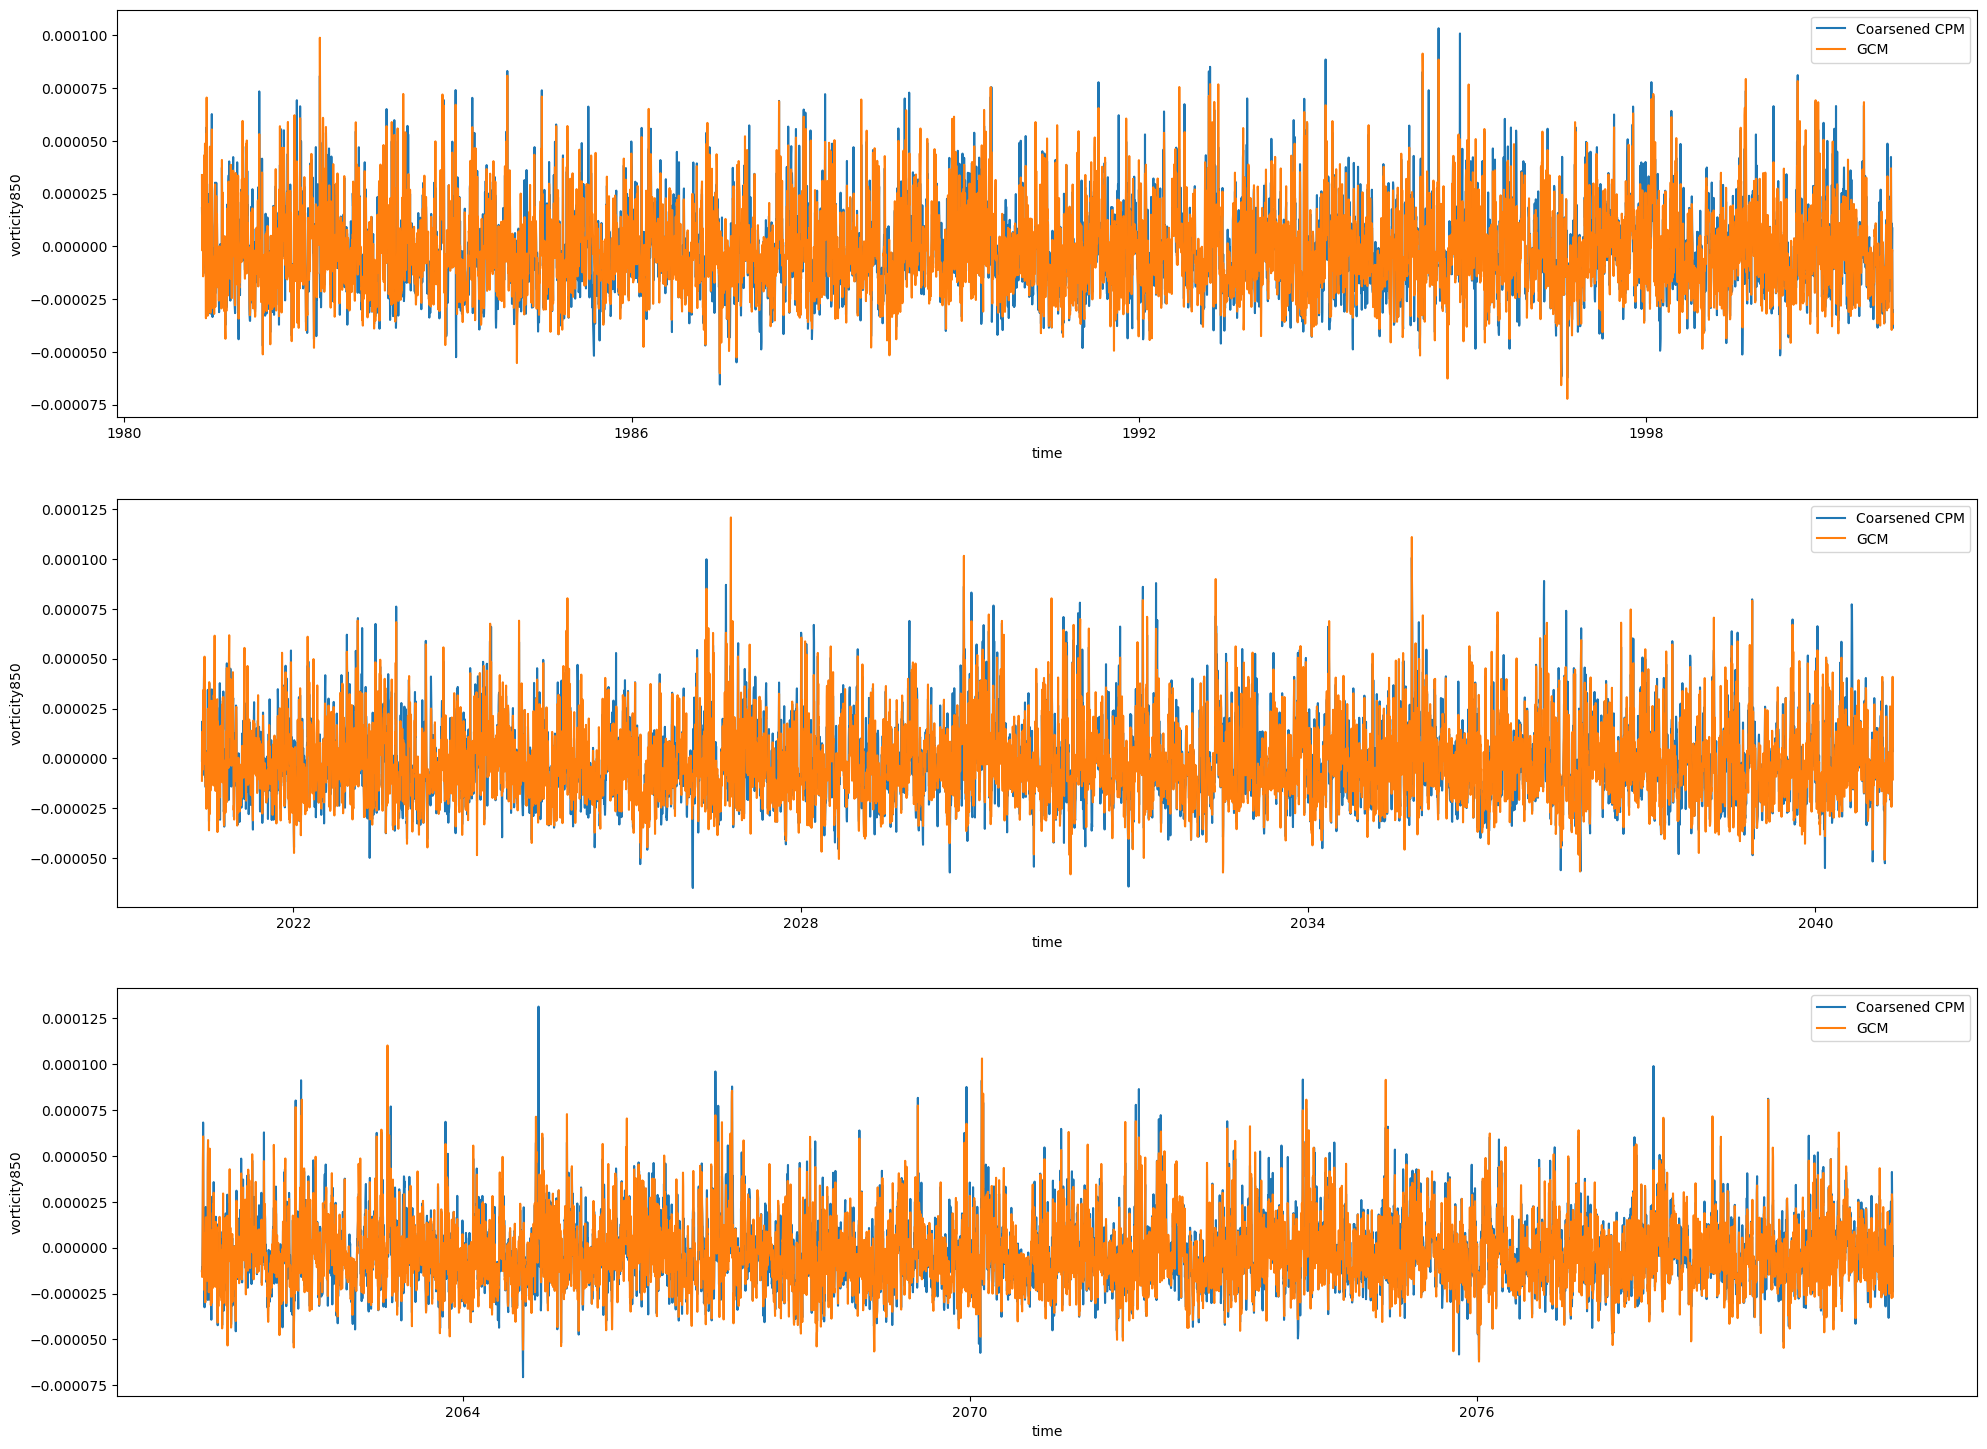

In [ ]:
time_slices = {
    "TS1": slice("1980-12-01", "2000-12-01"),
    "TS2": slice("2020-12-01", "2040-12-01"),
    "TS3": slice("2060-12-01", "2080-12-01"),
}

fig, axd = plt.subplot_mosaic(np.array(list(time_slices.keys())).reshape(3,1), figsize=(24,18))

cpm_coarsened_mean = cpm_coarsened_ds[VARIABLE].mean(dim=["grid_longitude", "grid_latitude"])
gcm_mean = gcm_ds[VARIABLE].mean(dim=["grid_longitude", "grid_latitude"])

for ts, time_query in time_slices.items():
    ax = axd[ts]
    cpm_coarsened_mean.sel(time=time_query).plot(ax=ax, label="Coarsened CPM")
    gcm_mean.sel(time=time_query).plot(ax=ax, label="GCM")
    ax.legend()

plt.show()

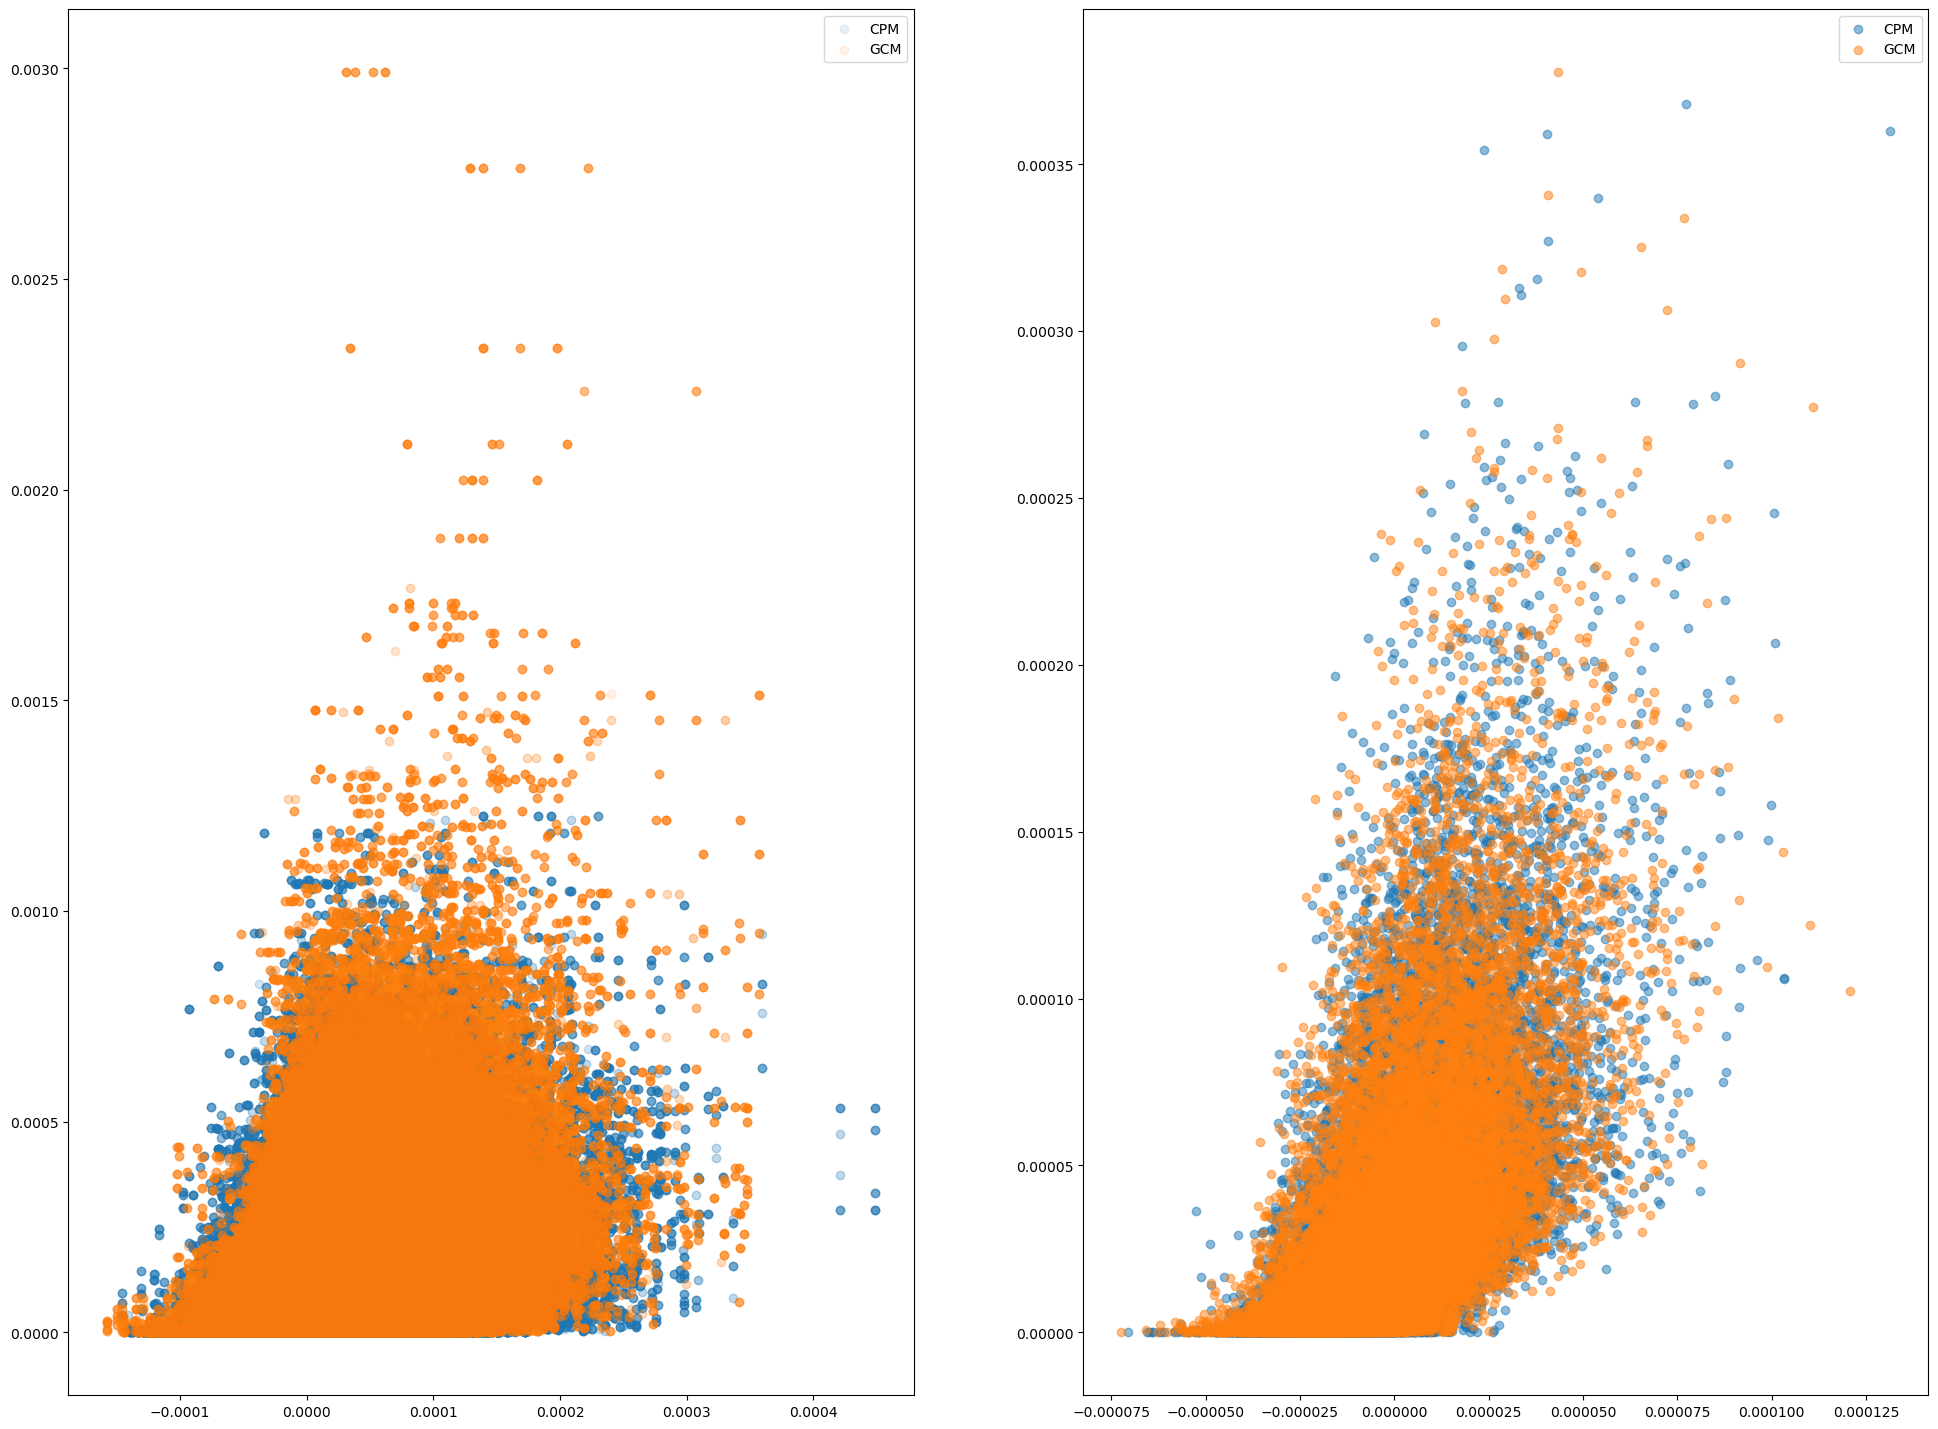

In [ ]:
fig, axd = plt.subplot_mosaic([["pixels", "mean"]], figsize=(24,18))

ax = axd["pixels"]

coarsened_cpm_pr_var_ds = xr.merge([cpm_coarsened_ds, open_ds("2.2km-coarsened-gcm", variable="pr")])
ax.scatter(x=coarsened_cpm_pr_var_ds["vorticity850"], y=coarsened_cpm_pr_var_ds["pr"], alpha=0.1, label="CPM")

gcm_pr_var_ds = xr.merge([gcm_ds, open_ds("60km", variable="pr")])
ax.scatter(x=gcm_pr_var_ds["vorticity850"], y=gcm_pr_var_ds["pr"], alpha=0.1, label="GCM")

ax.legend()

ax = axd["mean"]

coarsened_cpm_mean_ds = coarsened_cpm_pr_var_ds.mean(dim=["grid_longitude", "grid_latitude"])
ax.scatter(x=coarsened_cpm_mean_ds["vorticity850"], y=coarsened_cpm_mean_ds["pr"], alpha=0.5, label="CPM")

gcm_mean_ds = gcm_pr_var_ds.mean(dim=["grid_longitude", "grid_latitude"])
ax.scatter(x=gcm_mean_ds["vorticity850"], y=gcm_mean_ds["pr"], alpha=0.5, label="GCM")

ax.legend()


plt.show()